# Loading Important Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

In [2]:
FIG_DIR = "./figures"

# Load & Explore all the CSVs

In [3]:
tx = pd.read_csv("transactions_train.csv")
cu = pd.read_csv("customers.csv")
ar = pd.read_csv("articles.csv")

## Customers

In [4]:
cu.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [5]:
cu.columns

Index(['customer_id', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age', 'postal_code'],
      dtype='object')

In [6]:
cu.shape

(1371980, 7)

In [7]:
cu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355969 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


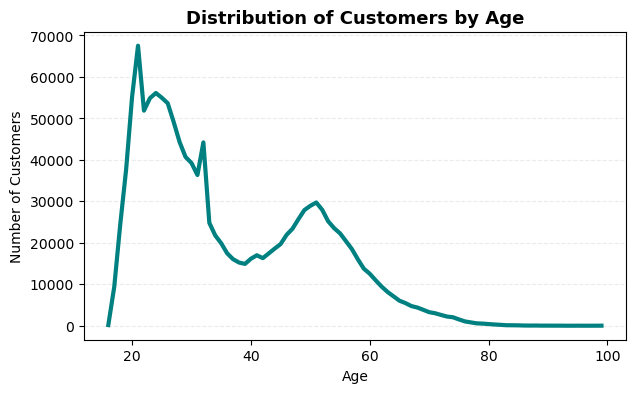

In [148]:
plt.figure(figsize=(7,4))

a = cu.groupby("age")["customer_id"].count().plot(color="teal", linewidth=3)
plt.title("Distribution of Customers by Age", fontsize=13, fontweight="bold")
plt.xlabel("Age")
plt.ylabel("Number of Customers")
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.savefig(f"{FIG_DIR}/cust_age.png", dpi=150, bbox_inches="tight")
plt.show()


#### Distribution of Customers by Age

This chart shows how customers are distributed across different age groups.

- Most customers are between **20 and 35 years old**, showing that H&M’s main customer base is young and adults.
- The number of customers starts to drop after the mid-30s and continues to decline with age.
- There is a small rise again around **50–55 years**, which could represent an older segment of regular shoppers.
- Very few customers are above 70 years old.

Overall, the plot suggests that H&M mainly attracts **younger adults**, which aligns with its fashion-forward and trend-focused product lines.


In [9]:
cu.isna().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16011
age                        15861
postal_code                    0
dtype: int64

In [10]:
for col in ["FN", "Active", "club_member_status", "fashion_news_frequency"]:
    print(col)
    print(cu[col].unique())
    print('**********************')

FN
[nan  1.]
**********************
Active
[nan  1.]
**********************
club_member_status
['ACTIVE' nan 'PRE-CREATE' 'LEFT CLUB']
**********************
fashion_news_frequency
['NONE' 'Regularly' nan 'Monthly']
**********************


#### Cleaning Customers Data

In [11]:
cu["club_member_status"] = cu["club_member_status"].fillna('INACTIVE')
cu["club_member_status"] = cu["club_member_status"].replace(["PRE-CREATE"], "INACTIVE")
cu["club_member_status"] = cu["club_member_status"].replace(["LEFT CLUB"], "INACTIVE")

In [12]:
cu["fashion_news_frequency"] = cu["fashion_news_frequency"].fillna('NONE')

In [13]:
cu["FN"] = cu["FN"].fillna(0)
cu["Active"] = cu["Active"].fillna(0)

In [14]:
cu["age"] = cu["age"].fillna(cu["age"].median())

In [15]:
cu.isna().sum()

customer_id               0
FN                        0
Active                    0
club_member_status        0
fashion_news_frequency    0
age                       0
postal_code               0
dtype: int64

In [16]:
cu["age_bucket"] = pd.cut(cu["age"], bins=[0,18,25,35,45,60,120], 
                            labels=["<18","18-24","25-34","35-44","45-59","60+"], 
                            include_lowest=True).astype("category")

#### Handling Missing Values in Customer Data

Before analyzing the customer dataset, it is important to handle missing values and make sure all columns are consistent.

The table above shows that several columns have missing entries — especially `FN`, `Active`, `club_member_status`, `fashion_news_frequency`, and `age`.  
To fix this, the following steps were taken:

- **Club Member Status:**  
  - Missing values were filled with `'INACTIVE'`.  
  - Other non-active statuses like `'PRE-CREATE'` and `'LEFT CLUB'` were also replaced with `'INACTIVE'` to simplify the category.
  - This helps create a clear distinction between **active** and **inactive** customers.

- **Fashion News Frequency:**  
  - Missing values were replaced with `'NONE'`, assuming those customers do not receive fashion news updates.

- **FN (Fashion Newsletter Subscription) and Active:**  
  - These are binary columns (1 = Yes, 0 = No).  
  - Missing values were replaced with `0`, meaning those customers are not subscribed or inactive.

- **Age:**  
  - Missing age values were filled using the **median age** of all customers.  
  - The median is used instead of the mean to reduce the impact of outliers.



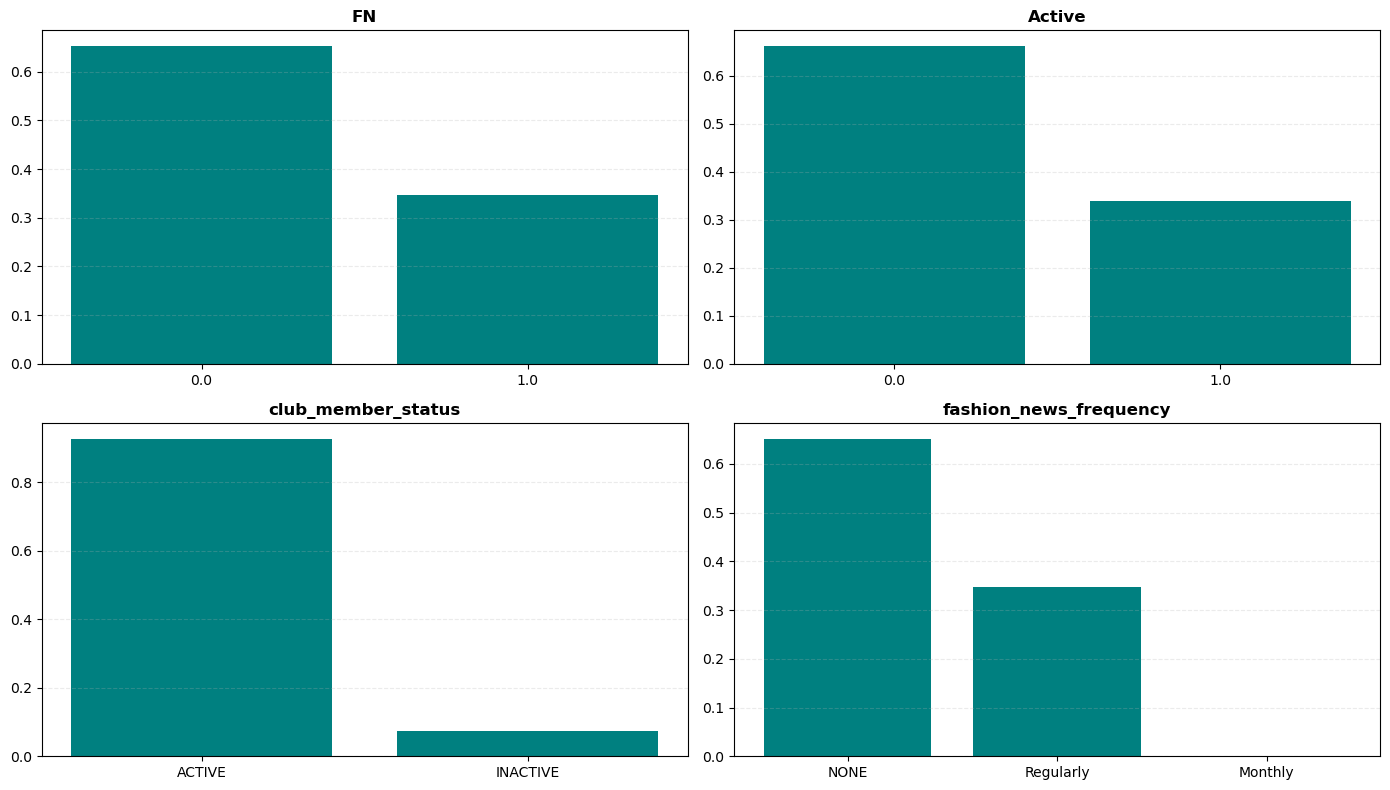

In [173]:
cols = ["FN", "Active", "club_member_status", "fashion_news_frequency"]

fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()  

for i, col in enumerate(cols):
    a = cu[col].value_counts(normalize=True)
    axes[i].bar(a.index.astype(str), a.values, label=col, color='teal')
    axes[i].set_title(col, fontsize=12, fontweight='bold')
    axes[i].grid(axis='y', linestyle='--', alpha=0.25)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/cust_othercols_bar.png", dpi=150)
plt.show()

#### Distribution of Key Customer Attributes

The charts above show the distribution of four important customer-related columns after cleaning the data.

- **FN (Fashion Newsletter Subscription):**  
  Around **35%** of customers are subscribed to the fashion newsletter (`1`), while about **65%** are not (`0`).

- **Active (Communication Status):**  
  Similar to the newsletter data, about **one-third** of customers are active for communication, and the remaining **two-thirds** are inactive.

- **Club Member Status:**  
  A large majority (around **90%**) of customers are **active club members**, while only a small portion are inactive.  
  This shows that most H&M customers are engaged in the loyalty program.

- **Fashion News Frequency:**  
  Most customers (**about 65%**) have their fashion news frequency set to **"NONE"**, meaning they don’t receive updates.  
  Around **35%** receive news either *regularly* or *monthly*.

Overall, the charts show that while many customers are part of the loyalty program, only a smaller portion actively engages with communication and newsletter updates.


In [18]:
a

fashion_news_frequency
NONE         0.651410
Regularly    0.347976
Monthly      0.000614
Name: proportion, dtype: float64

## Articles

In [19]:
ar.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [20]:
ar.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

In [21]:
ar.shape

(105542, 25)

In [22]:
ar.isna().sum()

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
graphical_appearance_no           0
graphical_appearance_name         0
colour_group_code                 0
colour_group_name                 0
perceived_colour_value_id         0
perceived_colour_value_name       0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

In [23]:
ar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

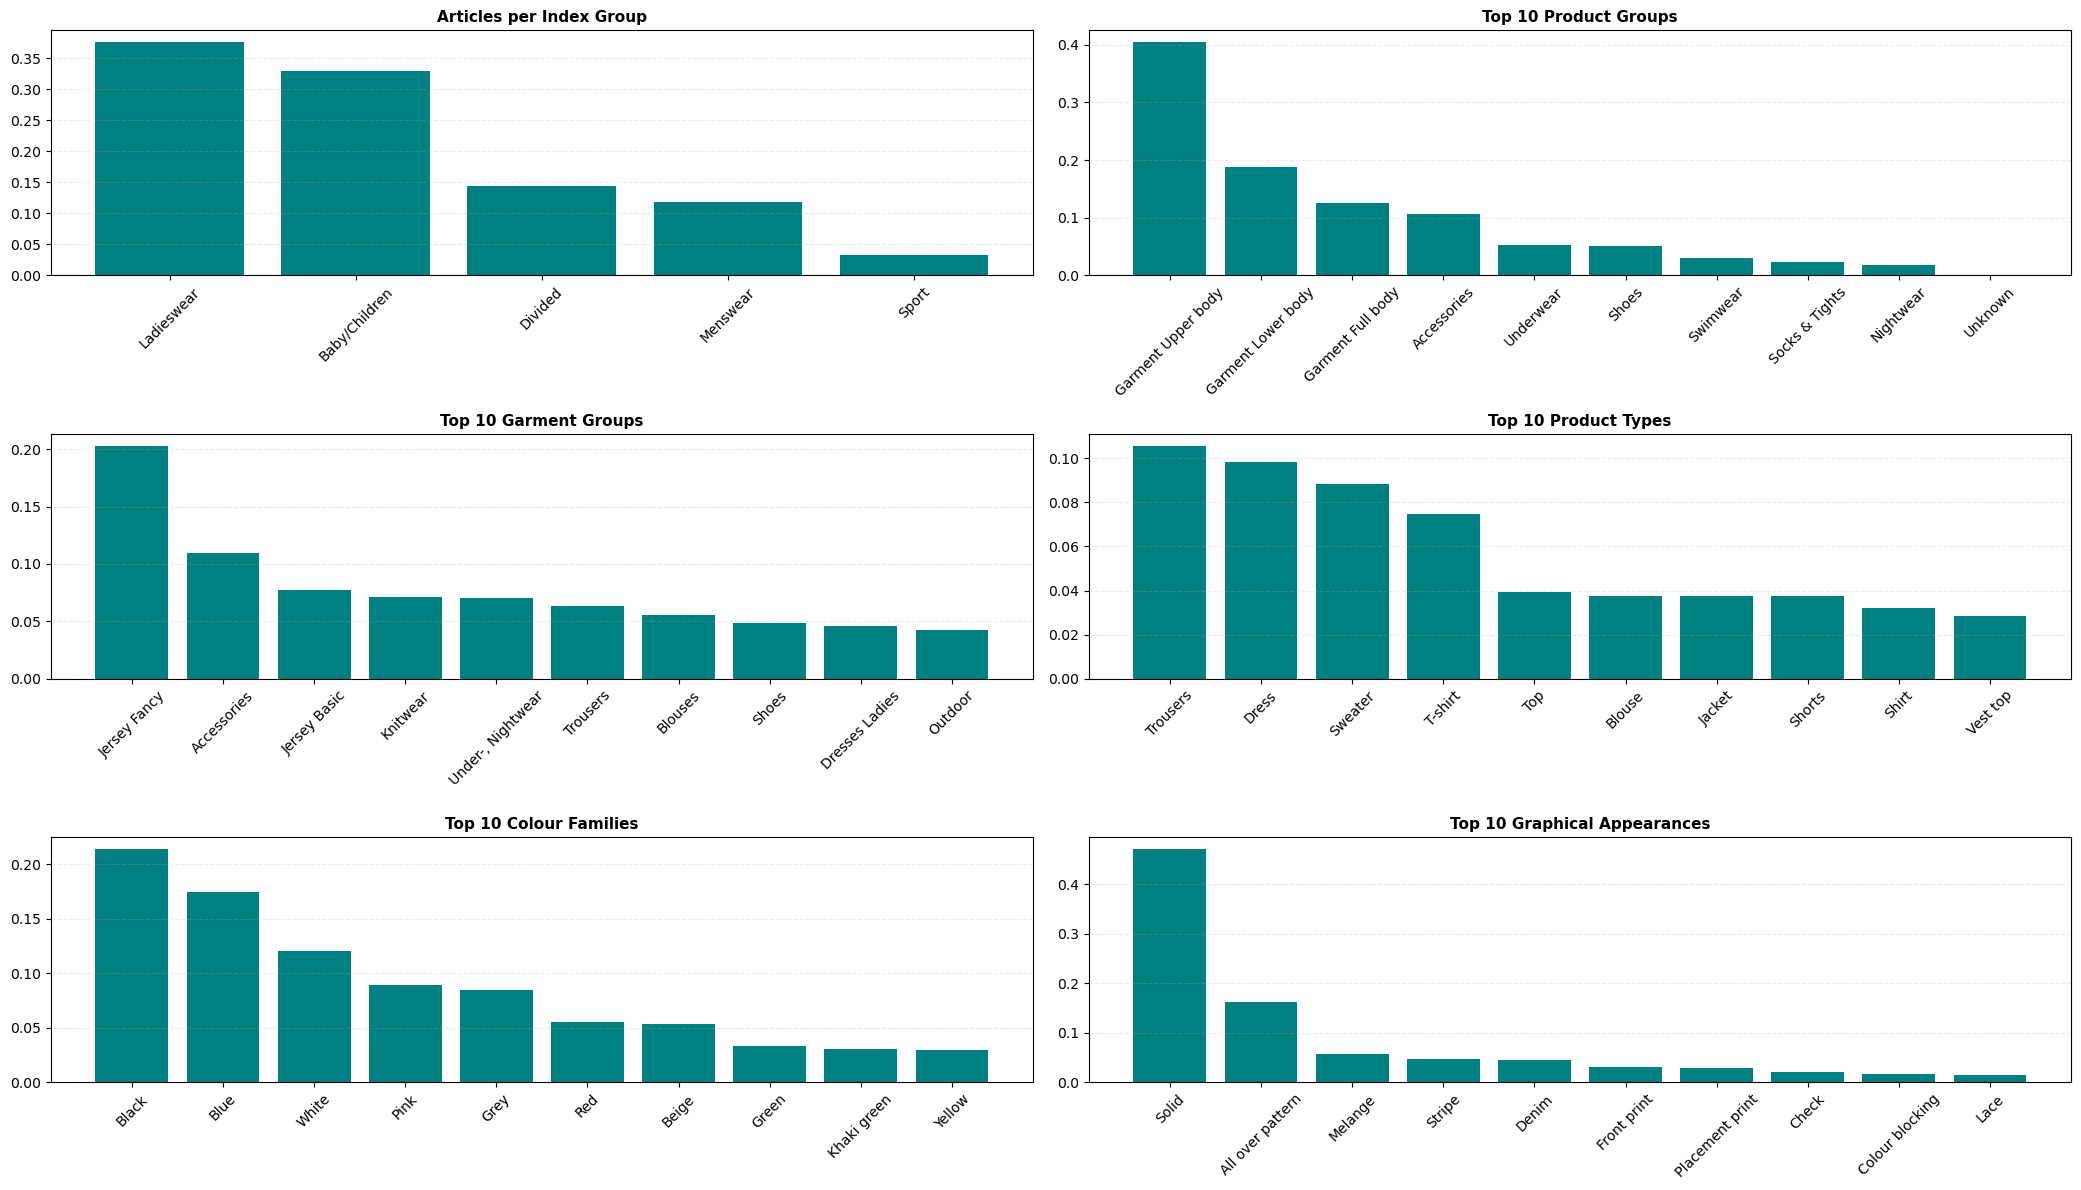

In [140]:
top_product_groups = ar['product_group_name'].value_counts(normalize=True).head(10)
top_garment_groups = ar['garment_group_name'].value_counts(normalize=True).head(10)
top_colour_families = ar['perceived_colour_master_name'].value_counts(normalize=True).head(10)
top_index_groups = ar['index_group_name'].value_counts(normalize=True)
top_graphical_appearances = ar['graphical_appearance_name'].value_counts(normalize=True).head(10)
top_product_types = ar['product_type_name'].value_counts(normalize=True).head(10)

fig, axes = plt.subplots(3, 2, figsize=(21, 12))
axes = axes.flatten()

plots = [
    (top_index_groups, 'Articles per Index Group', 'Index Group Name', 'blue'),
    (top_product_groups, 'Top 10 Product Groups', 'Product Group Name', 'skyblue'),
    (top_garment_groups, 'Top 10 Garment Groups', 'Garment Group Name', 'grey'),
    (top_product_types, 'Top 10 Product Types', 'Product Type Name', 'lightgrey'),
    (top_colour_families, 'Top 10 Colour Families', 'Perceived Colour Family', 'palegreen'),
    (top_graphical_appearances, 'Top 10 Graphical Appearances', 'Graphical Appearance', 'green'),

]

for i, (data, title, xlabel, color) in enumerate(plots):
    axes[i].bar(data.index, data.values, color='teal', label=title)
    axes[i].set_title(title, fontsize=11, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.25)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/articles_eda_overview.png", dpi=150, bbox_inches='tight')
plt.show()


#### Overview of Articles Data

The charts above summarize the main features of the products sold at H&M.

- **Ladieswear** and **Baby/Children** are the biggest index groups, showing that these are H&M’s main focus areas.  
- Within product groups, **Garment Upper Body** (like tops and shirts) and **Garment Lower Body** (like trousers and skirts) dominate the catalog.  
- The most common garment types are **Jersey Fancy**, **Accessories**, and **Knitwear**.  
- The most frequent product types include **Trousers**, **Dresses**, and **Sweaters**, which are key parts of most wardrobes.  
- When it comes to color, **Black**, **Blue**, and **White** are the most common, suggesting neutral tones are preferred by customers.  
- **Solid designs** are the most popular graphical appearance, showing that simple, clean styles dominate H&M’s product line.

Overall, this shows H&M offers a large variety of products, with a strong focus on casual wear and neutral-colored essentials.


## Transactions

In [25]:
tx.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [26]:
tx.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id'], dtype='object')

In [27]:
tx['t_dat'] = pd.to_datetime(tx['t_dat'], errors='coerce')

start_date = tx['t_dat'].min()
end_date = tx['t_dat'].max()

In [28]:
print(f"The Transactions are present from {start_date.date()} to {end_date.date()}")

The Transactions are present from 2018-09-20 to 2020-09-22


In [29]:
tx.shape

(31788324, 5)

In [30]:
tx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   t_dat             datetime64[ns]
 1   customer_id       object        
 2   article_id        int64         
 3   price             float64       
 4   sales_channel_id  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.2+ GB


In [31]:
tx.isna().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

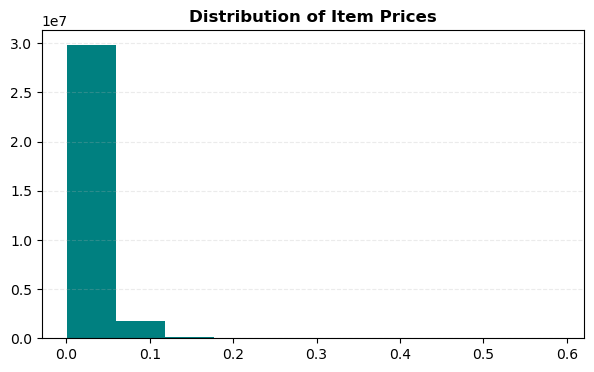

In [172]:
plt.figure(figsize=(7,4))
plt.title('Distribution of Item Prices', fontsize=12, fontweight='bold')
plt.hist(tx['price'], color='teal')
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.show()

In [33]:
channel_counts = tx['sales_channel_id'].value_counts(normalize=True).rename(index={1: 'Online', 2: 'In-store'})
channel_counts

sales_channel_id
In-store    0.704028
Online      0.295972
Name: proportion, dtype: float64

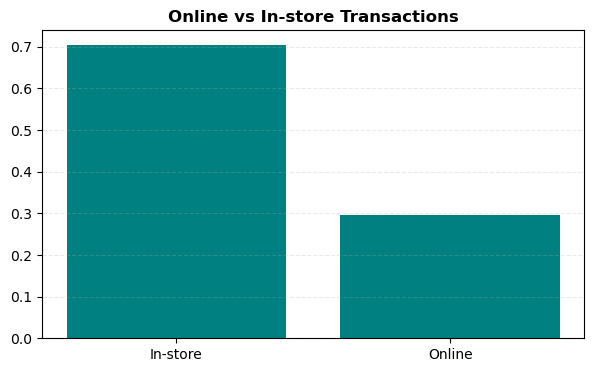

In [146]:
plt.figure(figsize=(7,4))
plt.bar(channel_counts.index.astype(str), channel_counts.values, color='teal')
plt.title('Online vs In-store Transactions', fontsize=12, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.savefig(f"{FIG_DIR}/transactions_channel.png", dpi=150, bbox_inches='tight')
plt.show()


#### Online vs In-Store Transactions

This chart compares the share of online and in-store purchases.

- **In-store transactions** make up the majority of total sales.  
- This suggests that customers still prefer physical shopping, likely for the in-person experience and the ability to try on items.  
- **Online sales** still represent a significant share, showing that digital channels are growing in importance.

H&M can use this insight to strengthen both channels—focusing on **personalized online recommendations** and **cross-selling in stores** to enhance the overall shopping experience.


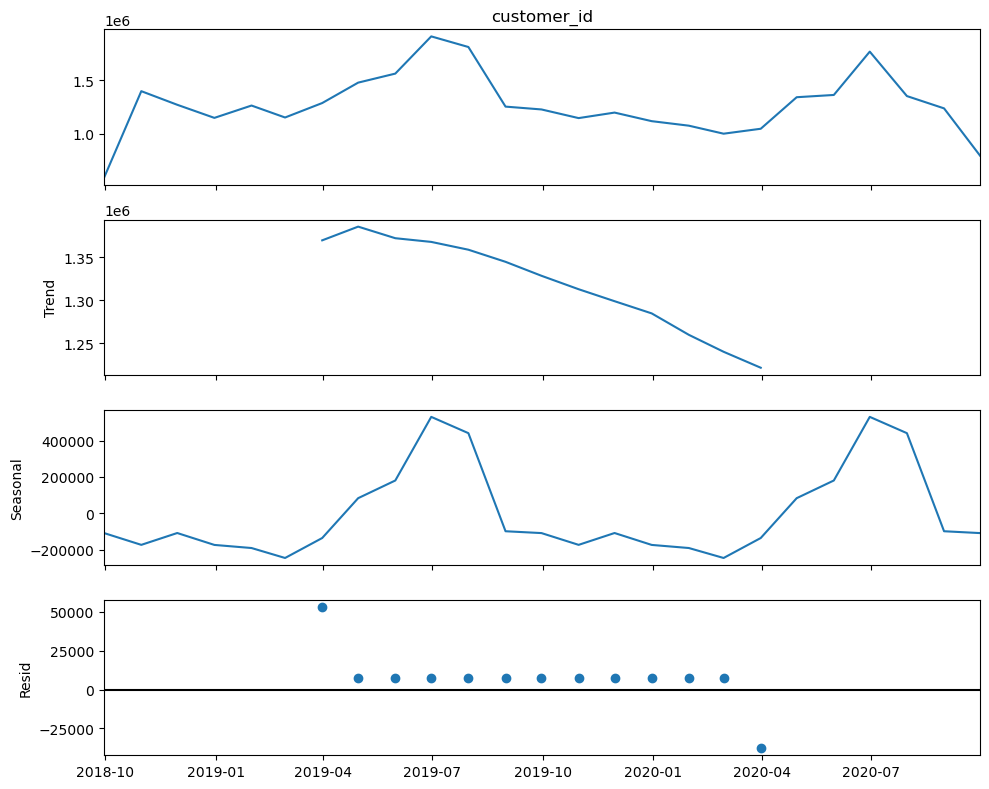

In [154]:
ts_monthly = tx.groupby(pd.Grouper(key='t_dat', freq='M'))['customer_id'].count()
ts_monthly = ts_monthly.asfreq('M').fillna(0)

result_monthly = seasonal_decompose(ts_monthly, model='additive', period=12)
plt.rcParams.update({'figure.figsize': (10,8)})
result_monthly.plot()
plt.savefig(f"{FIG_DIR}/transactions_seasonality.png", dpi=150, bbox_inches='tight')
plt.show()



#### Seasonality and Transaction Trends

The time-series decomposition shows how sales change over time.

- There is a clear **seasonal pattern**, with peaks in the **middle of each year**, possibly due to summer collections or mid-year sales.  
- The overall trend shows slight growth early on, followed by a gradual decline in 2020, which might be linked to the pandemic’s impact on shopping behavior.

These insights can help time marketing campaigns and inventory planning based on expected seasonal demand.


## Explanatory Data Analysis (EDA)

In [36]:
ar = ar[['article_id', 'prod_name', 'product_group_name', 'product_type_name', 'graphical_appearance_name', 'colour_group_name', 'perceived_colour_value_name',
        'perceived_colour_master_name', 'index_group_name', 'index_name', 'section_name', 'garment_group_name']]


In [37]:
combined_df = tx.merge(cu, on='customer_id', how='inner').merge(ar, on='article_id', how='inner')

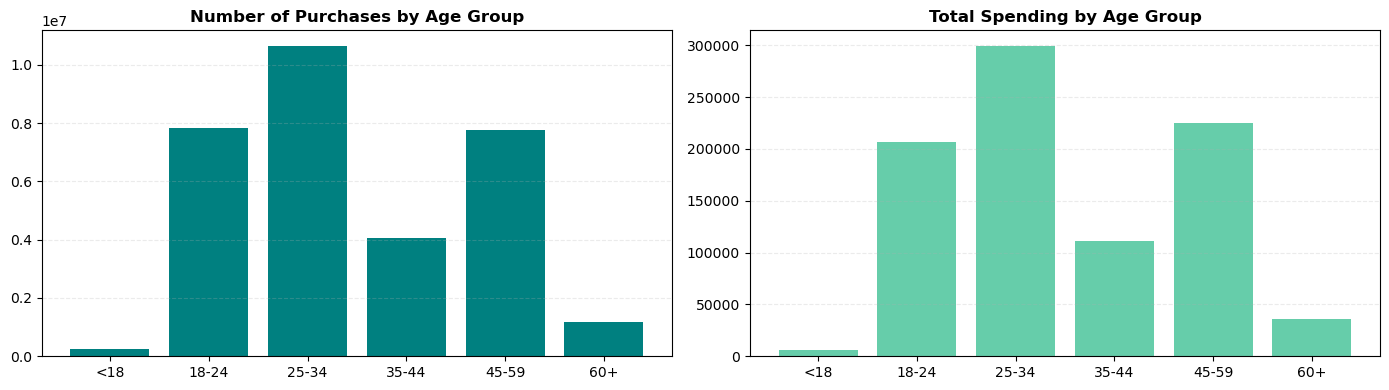

In [171]:
age_summary = combined_df.groupby('age_bucket').agg(
    purchase_count=('article_id', 'count'),
    total_spent=('price', 'sum')
).reset_index()

fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].bar(age_summary['age_bucket'], age_summary['purchase_count'], color='teal')
axes[1].bar(age_summary['age_bucket'], age_summary['total_spent'], color='mediumaquamarine')

axes[0].set_title('Number of Purchases by Age Group', fontsize=12, fontweight='bold')
axes[1].set_title('Total Spending by Age Group', fontsize=12, fontweight='bold')
for ax in axes:
    ax.grid(axis='y', linestyle='--', alpha=0.25)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/eda_age_spending.png", dpi=150, bbox_inches='tight')
plt.show()

### Q1 Purchases and Spending by Age Group

The charts show how the number of purchases and total spending vary across age groups.

- Customers aged **25–34 years** make the most purchases and have the highest total spending.  
- The **18–24** and **45–59** groups also show strong engagement, while younger (<18) and older (60+) groups shop less.  
- This means H&M’s main buyers are **young to middle-aged adults**, who contribute most to overall sales.

This information can help tailor marketing and recommendation strategies by age group.


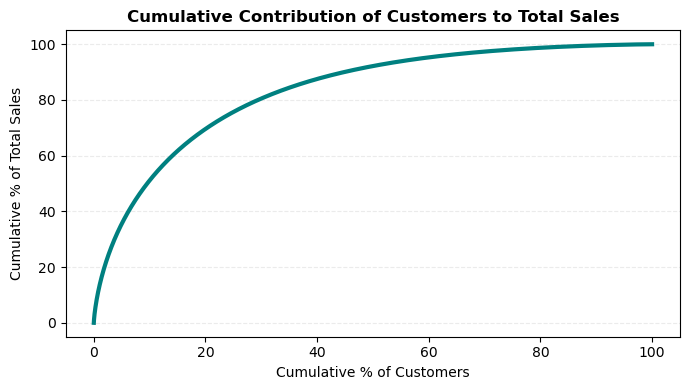

In [161]:

spend_per_customer = combined_df.groupby('customer_id')['price'].sum().sort_values(ascending=False).reset_index()

spend_per_customer['cum_share'] = spend_per_customer['price'].cumsum() / spend_per_customer['price'].sum()
spend_per_customer['rank'] = range(1, len(spend_per_customer) + 1)
spend_per_customer['cum_pct_users'] = spend_per_customer['rank'] / len(spend_per_customer)

plt.figure(figsize=(7,4))
plt.plot(spend_per_customer['cum_pct_users']*100, spend_per_customer['cum_share']*100, linewidth=3, color='teal')
plt.title('Cumulative Contribution of Customers to Total Sales', fontsize=12, fontweight='bold')
plt.xlabel('Cumulative % of Customers')
plt.ylabel('Cumulative % of Total Sales')
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/eda_pareto.png", dpi=150, bbox_inches='tight')
plt.show()


### Q2 Cumulative Contribution of Customers to Total Sales

This plot shows how much of the total revenue comes from different portions of customers.

- The curve follows the **80/20 rule**, meaning that about **20% of customers contribute to around 80% of total sales**.  
- Most of H&M’s sales are driven by a smaller group of high-value, loyal customers.

This highlights the importance of **retaining and rewarding top customers**, as they are key to sustaining revenue.


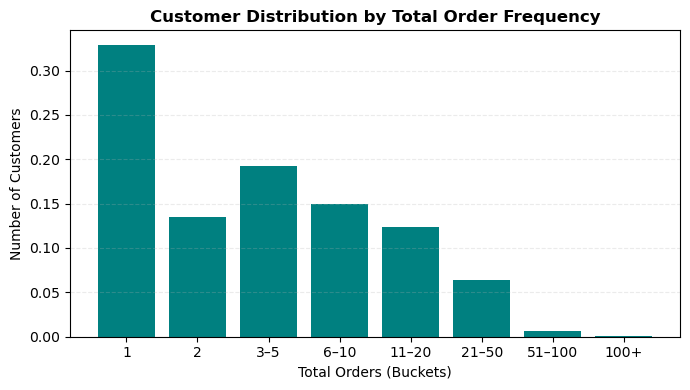

In [162]:
customer_orders = combined_df.groupby('customer_id')['t_dat'].nunique().reset_index()
customer_orders.rename(columns={'t_dat': 'total_orders'}, inplace=True)

bins = [0, 1, 2, 5, 10, 20, 50, 100, float('inf')]
labels = ['1', '2', '3–5', '6–10', '11–20', '21–50', '51–100', '100+']
customer_orders['order_bucket'] = pd.cut(customer_orders['total_orders'], bins=bins, labels=labels, right=True)

order_bucket_counts = customer_orders['order_bucket'].value_counts(normalize=True).sort_index()

plt.figure(figsize=(7,4))
plt.bar(order_bucket_counts.index.astype(str), order_bucket_counts.values, color='teal')
plt.title('Customer Distribution by Total Order Frequency', fontsize=12, fontweight='bold')
plt.xlabel('Total Orders (Buckets)')
plt.ylabel('Number of Customers')
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/eda_user_order_buckets.png", dpi=150, bbox_inches='tight')
plt.show()


In [163]:
order_bucket_counts.cumsum()

order_bucket
1         0.328840
2         0.463259
3–5       0.655896
6–10      0.805484
11–20     0.928717
21–50     0.992901
51–100    0.999367
100+      1.000000
Name: proportion, dtype: float64

#### Q3 Customer Distribution by Total Order Frequency

This chart shows how customers are spread across different order frequency groups.

- Around **one-third of customers** have made **only one purchase**, and about **half of the customers** have placed **two or fewer orders**.  
- The number of customers decreases as the order count increases, meaning **repeat buyers are fewer but more valuable**.  
- Only a very small percentage of customers have made more than **20 purchases**.

This suggests that while H&M has a large customer base, most are **occasional buyers**, showing an opportunity to improve **customer retention** and **loyalty** through personalized offers and rewards.


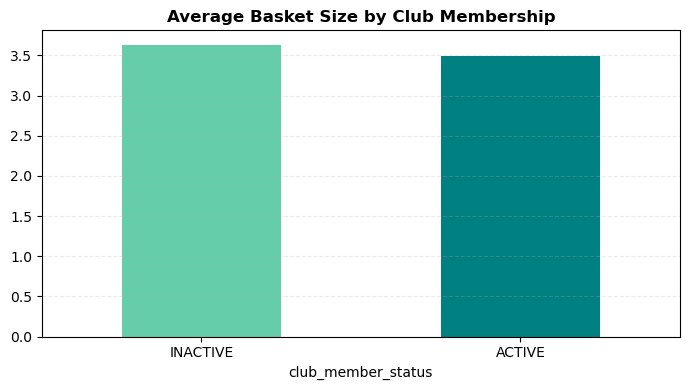

In [170]:
basket = combined_df.groupby(['customer_id', 't_dat']).agg(
    basket_size=('article_id', 'count')
).reset_index()

basket = basket.merge(cu[['customer_id', 'club_member_status']], on='customer_id', how='left')

basket_summary = basket.groupby('club_member_status')['basket_size'].mean().sort_values(ascending=False)

plt.figure(figsize=(7,4))
basket_summary.plot(kind='bar', color=['mediumaquamarine', 'teal'])
plt.title('Average Basket Size by Club Membership', fontsize=12, fontweight='bold')
plt.tick_params(axis='x', rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.25)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/eda_membership_basket.png", dpi=150, bbox_inches='tight')
plt.show()


#### Q4 Average Basket Size by Club Membership

This chart compares the average number of items purchased per day by **active** and **inactive** club members.

- Surprisingly, **inactive members** have a slightly larger average basket size than active ones.  
- This could mean that inactive members shop less often but buy more items in a single visit, while active members might make smaller, more frequent purchases.

This insight can help in designing membership engagement strategies—for example, encouraging inactive members with personalized offers to shop more regularly.


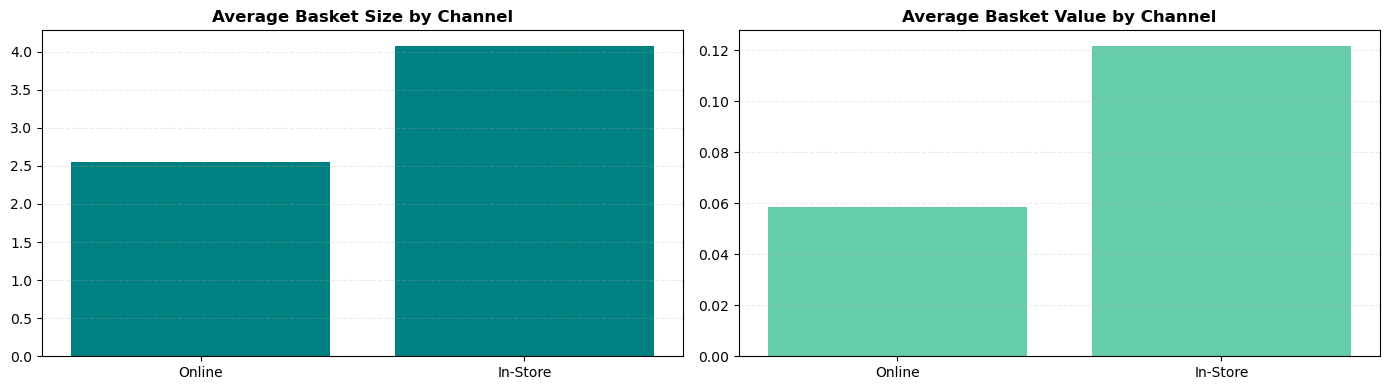

In [169]:
basket = combined_df.groupby(['customer_id', 't_dat', 'sales_channel_id']).agg(
    basket_size=('article_id', 'count'),
    basket_value=('price', 'sum')
).reset_index()

channel_summary = basket.groupby('sales_channel_id')[['basket_size', 'basket_value']].mean().reset_index()
channel_summary['sales_channel'] = channel_summary['sales_channel_id'].map({1:'Online', 2:'In-Store'})


fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].bar(channel_summary['sales_channel'], channel_summary['basket_size'], color='teal')
axes[0].set_title('Average Basket Size by Channel', fontsize=12, fontweight='bold')
#axes[0].set_ylabel('Items per Basket')
axes[0].grid(axis='y', linestyle='--', alpha=0.25)

axes[1].bar(channel_summary['sales_channel'], channel_summary['basket_value'], color='mediumaquamarine')
axes[1].set_title('Average Basket Value by Channel', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', linestyle='--', alpha=0.25)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/eda_sale_by_basket.png", dpi=150, bbox_inches='tight')
plt.show()


#### Q5 Average Basket Size and Value by Channel

These charts compare the **average number of items per purchase** and the **average total spending** between **online** and **in-store** customers.

- **In-store shoppers** buy more items (larger basket size) and spend more per transaction compared to online shoppers.  
- This means people shopping in stores tend to make **bigger purchases**, possibly because they can browse items physically or make impulse decisions.  
- **Online shoppers**, on the other hand, buy fewer items per order.

This shows that H&M’s physical stores still encourage higher spending per visit, while online sales are more focused and item-specific.


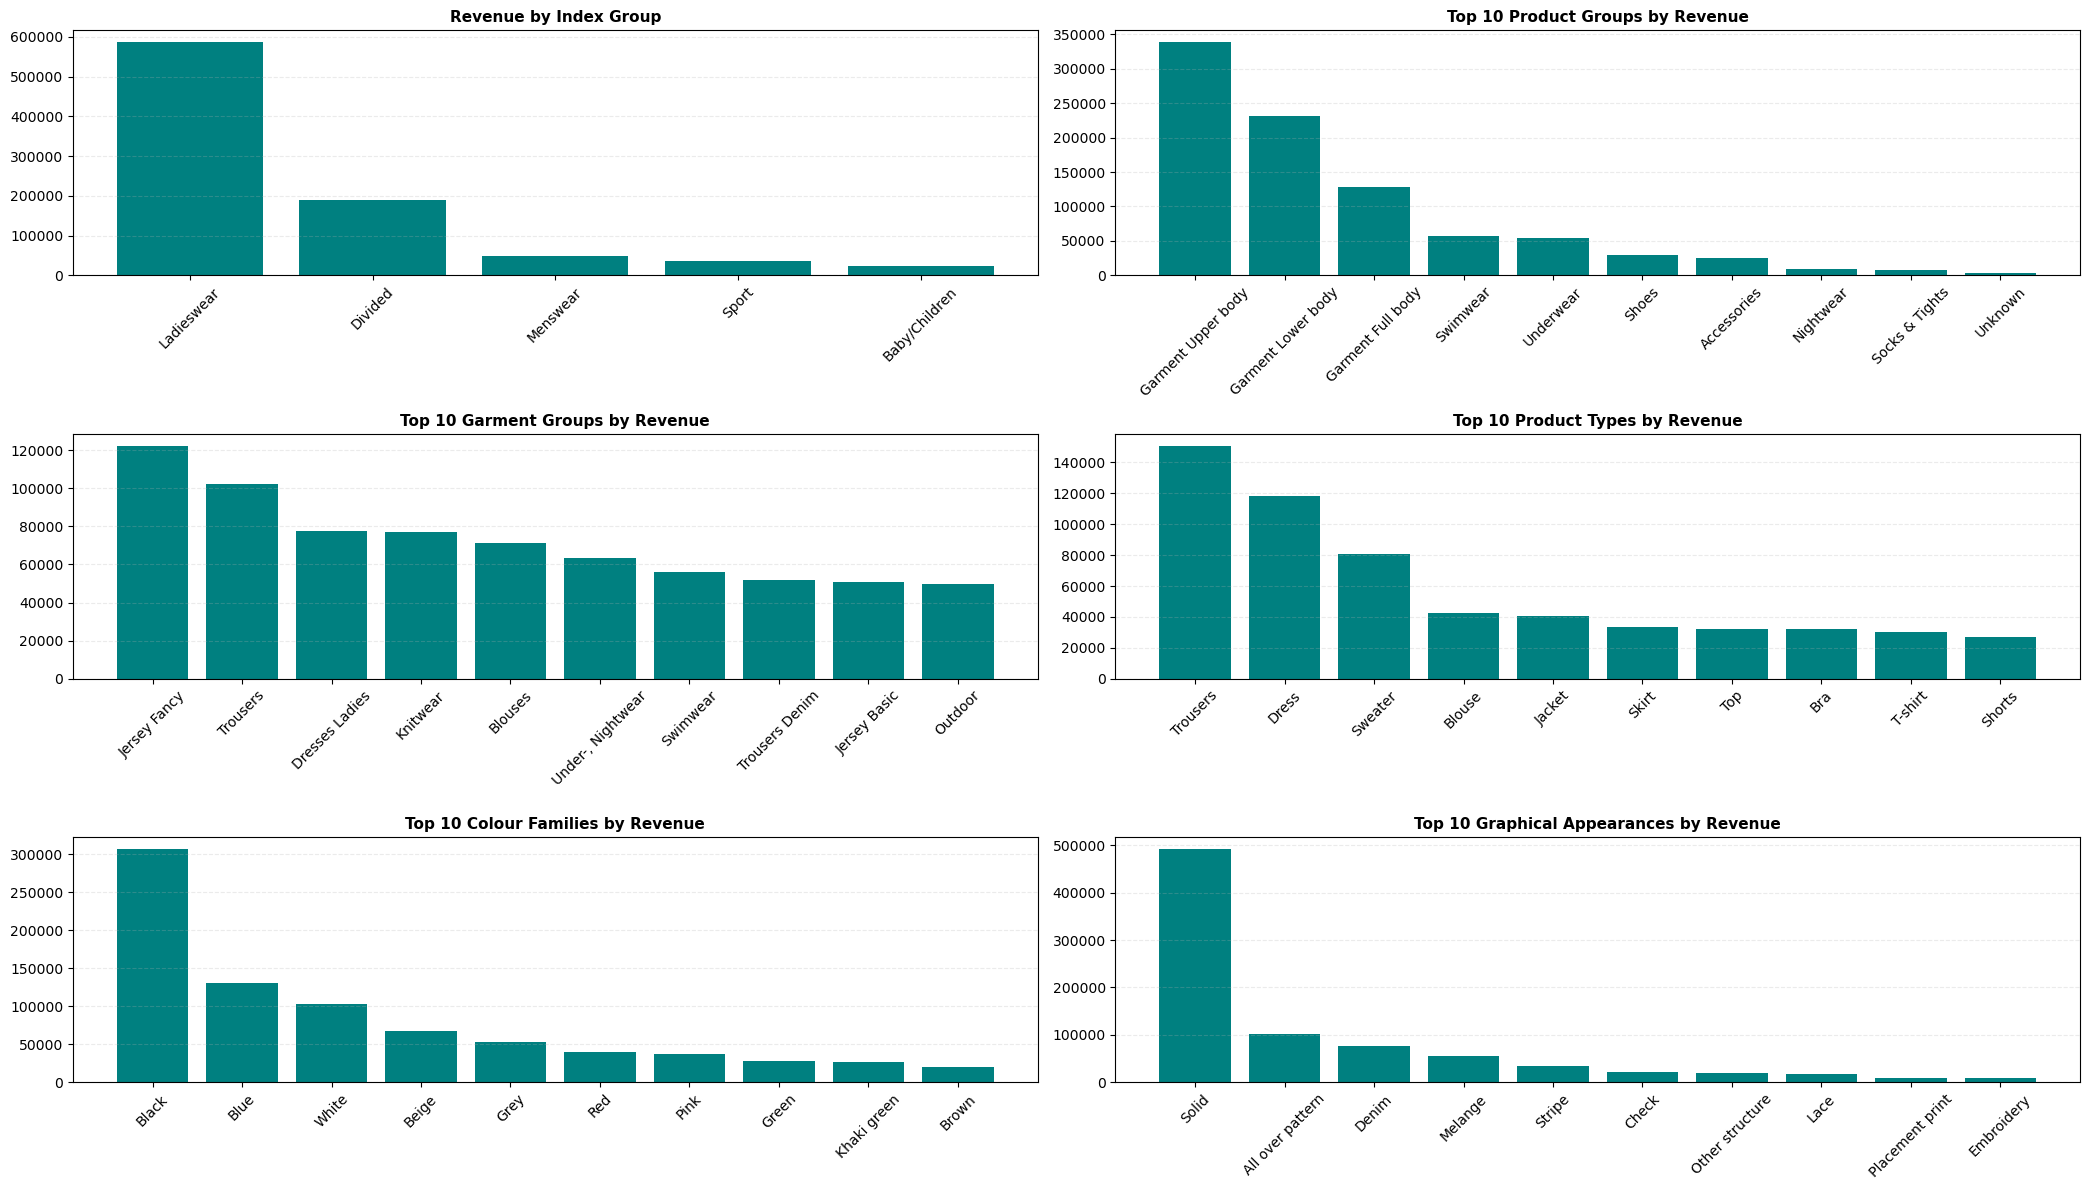

In [174]:
top_product_groups_rev = combined_df.groupby('product_group_name')['price'].sum().sort_values(ascending=False).head(10)
top_garment_groups_rev = combined_df.groupby('garment_group_name')['price'].sum().sort_values(ascending=False).head(10)
top_colour_families_rev = combined_df.groupby('perceived_colour_master_name')['price'].sum().sort_values(ascending=False).head(10)
top_index_groups_rev = combined_df.groupby('index_group_name')['price'].sum().sort_values(ascending=False)
top_graphical_appearances_rev = combined_df.groupby('graphical_appearance_name')['price'].sum().sort_values(ascending=False).head(10)
top_product_types_rev = combined_df.groupby('product_type_name')['price'].sum().sort_values(ascending=False).head(10)

fig, axes = plt.subplots(3, 2, figsize=(21, 12))
axes = axes.flatten()

plots_rev = [
    (top_index_groups_rev, 'Revenue by Index Group', 'Index Group Name'),
    (top_product_groups_rev, 'Top 10 Product Groups by Revenue', 'Product Group Name'),
    (top_garment_groups_rev, 'Top 10 Garment Groups by Revenue', 'Garment Group Name'),
    (top_product_types_rev, 'Top 10 Product Types by Revenue', 'Product Type Name'),
    (top_colour_families_rev, 'Top 10 Colour Families by Revenue', 'Perceived Colour Family'),
    (top_graphical_appearances_rev, 'Top 10 Graphical Appearances by Revenue', 'Graphical Appearance'),
]

for i, (data, title, xlabel) in enumerate(plots_rev):
    axes[i].bar(data.index, data.values, color='teal', label=title)
    axes[i].set_title(title, fontsize=11, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(axis='y', linestyle='--', alpha=0.25)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/eda_articles_revenue.png", dpi=150, bbox_inches='tight')
plt.show()


#### Q6 Product Revenue Insights

The charts above show which product categories, groups, and colors bring in the most revenue.

- **Ladieswear** contributes the highest revenue among all index groups.  
- In product categories, **Garment Upper Body** and **Garment Lower Body** generate the most sales, with **Trousers**, **Dresses**, and **Sweaters** leading by product type.  
- **Black**, **Blue**, and **White** items make the most money, confirming that neutral tones not only dominate the catalog but also drive sales.  
- **Solid designs** generate far more revenue than patterned styles, showing customer preference for classic looks.

This analysis shows that H&M’s main revenue drivers are **casual everyday wear in neutral colors**—core products that appeal to a wide audience.


In [46]:
from itertools import combinations
from collections import Counter

In [50]:
basket_data = combined_df[['customer_id', 't_dat', 'product_type_name']].drop_duplicates()
transactions = basket_data.groupby(['customer_id', 't_dat'])['product_type_name'].apply(list)

In [51]:
pair_counts = Counter()

for items in transactions:
    if len(items) > 1:
        pairs = combinations(sorted(set(items)), 2)
        pair_counts.update(pairs)


In [52]:
pair_df = pd.DataFrame(pair_counts.items(), columns=['pair', 'count'])
pair_df = pair_df.sort_values(by='count', ascending=False).head(15)

pair_df[['Product 1', 'Product 2']] = pd.DataFrame(pair_df['pair'].tolist(), index=pair_df.index)
pair_df = pair_df[['Product 1', 'Product 2', 'count']]

print(pair_df)

      Product 1         Product 2   count
25      Sweater          Trousers  498353
22   Bikini top   Swimwear bottom  463018
115       Dress          Trousers  385100
215     T-shirt          Trousers  366980
162         Top          Trousers  339971
84       Blouse          Trousers  312649
10      Sweater               Top  272217
19          Bra  Underwear bottom  262678
12      T-shirt               Top  260369
9       Sweater           T-shirt  255601
50        Dress               Top  251357
120      Blouse             Dress  249641
3         Dress           Sweater  239259
89        Dress           T-shirt  238578
13      T-shirt          Vest top  215404


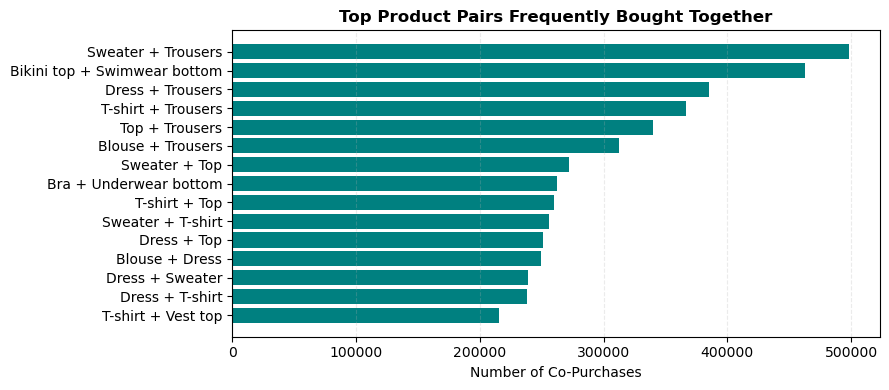

In [175]:

plt.figure(figsize=(9, 4))
plt.barh(
    y=pair_df['Product 1'] + " + " + pair_df['Product 2'],
    width=pair_df['count'],
    color='teal'
)

plt.title('Top Product Pairs Frequently Bought Together', fontsize=12, fontweight='bold')
plt.xlabel('Number of Co-Purchases')
plt.gca().invert_yaxis()  
plt.grid(axis='x', linestyle='--', alpha=0.25)
plt.tight_layout()
plt.savefig(f"{FIG_DIR}/eda_top_product_pairs.png", dpi=150, bbox_inches='tight')
plt.show()


#### Q7 Products Frequently Bought Together

This chart shows the top product pairs that customers often purchase in the same order.

- The most common combinations are **Sweater + Trousers**, **Bikini Top + Swimwear Bottom**, and **Dress + Trousers**.  
- Items like **T-shirts, Tops, and Sweaters** appear repeatedly, showing they are versatile pieces often bought with other products.  
- Customers tend to buy items that **complete an outfit** (like tops with trousers) or **belong to a matching set** (like swimwear or underwear).

These insights can help create better **cross-selling recommendations**, such as suggesting matching items or “complete the look” bundles.


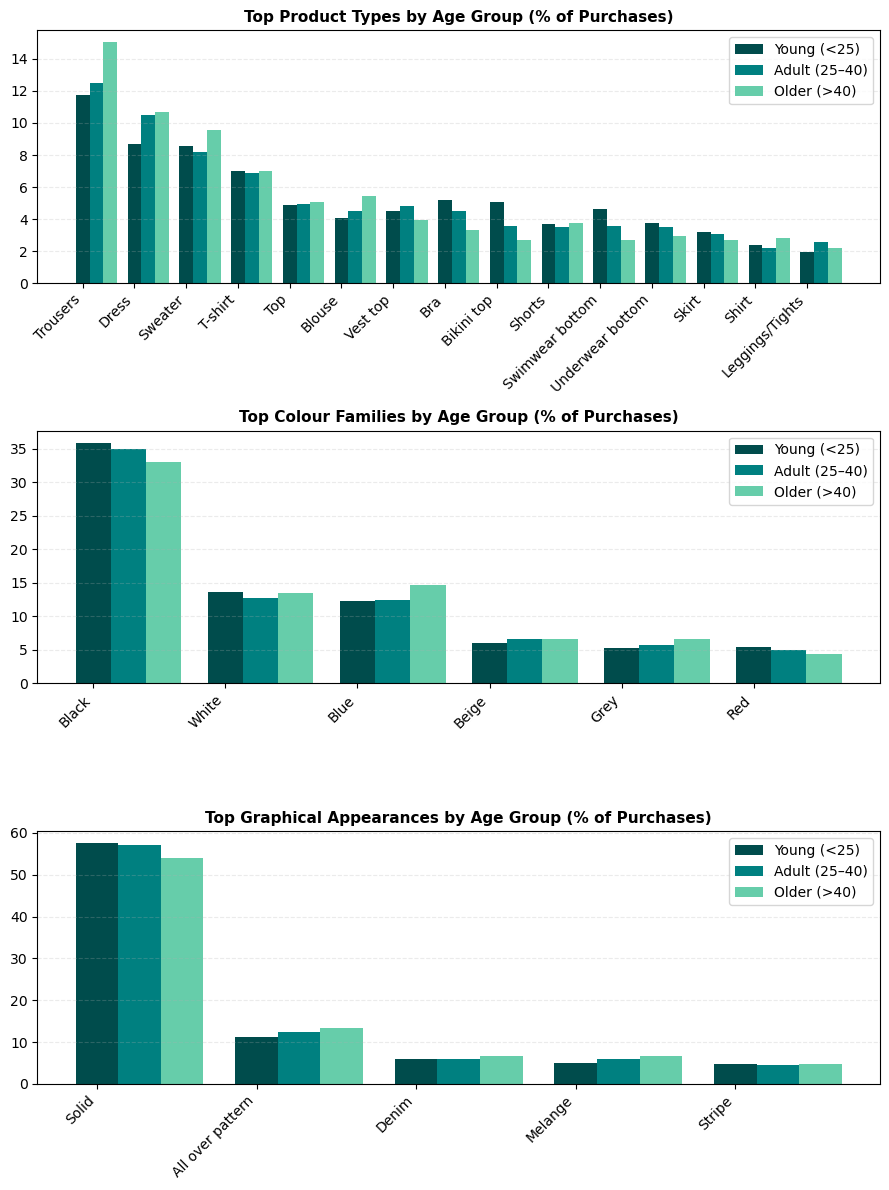

In [191]:
bins = [0, 25, 40, 100]
labels = ['Young (<25)', 'Adult (25–40)', 'Older (>40)']
combined_df['age_group'] = pd.cut(combined_df['age'], bins=bins, labels=labels, right=False)

def grouped_topk_plot_pct(df, cat_col, k, title, ax):
    ctab = df.groupby(['age_group', cat_col])['price'].count().rename('count').reset_index()
    totals = df.groupby('age_group')['price'].count()
    
    ctab['pct'] = ctab.apply(lambda row: (row['count'] / totals[row['age_group']]) * 100, axis=1)

    topk_sets = (
        ctab.sort_values(['age_group', 'pct'], ascending=[True, False])
            .groupby('age_group')
            .head(k)
    )
    top_union = sorted(topk_sets[cat_col].unique())

    full = (
        ctab[ctab[cat_col].isin(top_union)]
        .pivot(index=cat_col, columns='age_group', values='pct')
        .reindex(top_union)
        .fillna(0)
    )

    full = full.assign(_total=full.sum(axis=1)).sort_values('_total', ascending=False).drop(columns='_total')

    groups = full.index.tolist()
    age_groups = full.columns.tolist()
    x = np.arange(len(groups))
    width = 0.8 / len(age_groups)
    c = ['#004C4C', 'teal',  'mediumaquamarine']
    for i, ag in enumerate(age_groups):
        ax.bar(x + i * width - 0.4 + width * (len(age_groups) / 2),
               full[ag].values,
               width=width,
               label=ag, color = c[i])

    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(groups, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.25)
    ax.legend()

fig, axes = plt.subplots(3, 1, figsize=(9, 12))

grouped_topk_plot_pct(combined_df, 'product_type_name', k=15,
                      title='Top Product Types by Age Group (% of Purchases)', ax=axes[0])
grouped_topk_plot_pct(combined_df, 'perceived_colour_master_name', k=5,
                      title='Top Colour Families by Age Group (% of Purchases)', ax=axes[1])
grouped_topk_plot_pct(combined_df, 'graphical_appearance_name', k=5,
                      title='Top Graphical Appearances by Age Group (% of Purchases)', ax=axes[2])

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/eda_age_product_preferences.png", dpi=150, bbox_inches='tight')
plt.show()


#### Q8 Product and Style Preferences by Age Group

These charts compare how different age groups shop — focusing on **product type**, **color**, and **design pattern**.

- **Younger customers (<25)** prefer **casual and trendy clothing** like T-shirts, Tops, and Swimwear. They also buy more colorful items and patterns.  
- **Adults (25–40)** buy a mix of **Trousers, Dresses, and Sweaters**, showing balanced interest in both fashion and practicality.  
- **Older customers (>40)** prefer **Sweaters, Blouses, and classic items** in darker or neutral colors (like Black, Blue, Beige).  

Across all age groups, **Black and Solid-colored products** dominate purchases, showing that simple, versatile styles are preferred overall.

This helps create **age-based recommendation strategies** — for example, promoting trendy styles to younger users and comfortable classics to older customers.


In [109]:
cust_prod_counts = (
    combined_df.groupby(['customer_id', 'product_type_name'])['t_dat'].nunique().reset_index(name='purchase_count')
)

cust_prod_counts['purchase_label'] = cust_prod_counts['purchase_count'].apply(lambda x: 'once' if x == 1 else 'repeat')

product_repeat_stats = (
    cust_prod_counts.groupby(['product_type_name', 'purchase_label'])['customer_id']
    .nunique()
    .unstack(fill_value=0)
    .reset_index()
)

product_repeat_stats['repeat_ratio'] = (
    product_repeat_stats['repeat'] / (product_repeat_stats['once'] + product_repeat_stats['repeat'])
)

product_repeat_stats = product_repeat_stats[product_repeat_stats['once']>=pd.DataFrame(product_repeat_stats['once'].describe()).T['25%'].iloc[0]]

top_repeat = product_repeat_stats.sort_values('repeat_ratio', ascending=False).head(10)
bottom_repeat = product_repeat_stats.sort_values('repeat_ratio', ascending=True).head(10)

print("🔁 Top 10 Most Repeatedly Bought Product Types:")
print(top_repeat[['product_type_name', 'repeat_ratio']])

print("\n🚫 Bottom 10 Least Repeatedly Bought Product Types:")
print(bottom_repeat[['product_type_name', 'repeat_ratio']])


🔁 Top 10 Most Repeatedly Bought Product Types:
purchase_label product_type_name  repeat_ratio
111                     Trousers      0.564287
32                         Dress      0.528755
99                       Sweater      0.526877
104                      T-shirt      0.484251
107                          Top      0.461826
11                        Blouse      0.458692
15                           Bra      0.457874
120                     Vest top      0.427728
116             Underwear bottom      0.418743
89                         Skirt      0.401407

🚫 Bottom 10 Least Repeatedly Bought Product Types:
purchase_label product_type_name  repeat_ratio
49                      Hairband      0.018781
21                           Cap      0.018978
3                       Backpack      0.019359
64                   Mobile case      0.020103
38                Fine cosmetics      0.022589
18                        Braces      0.024299
19                    Bucket hat      0.025137
124     

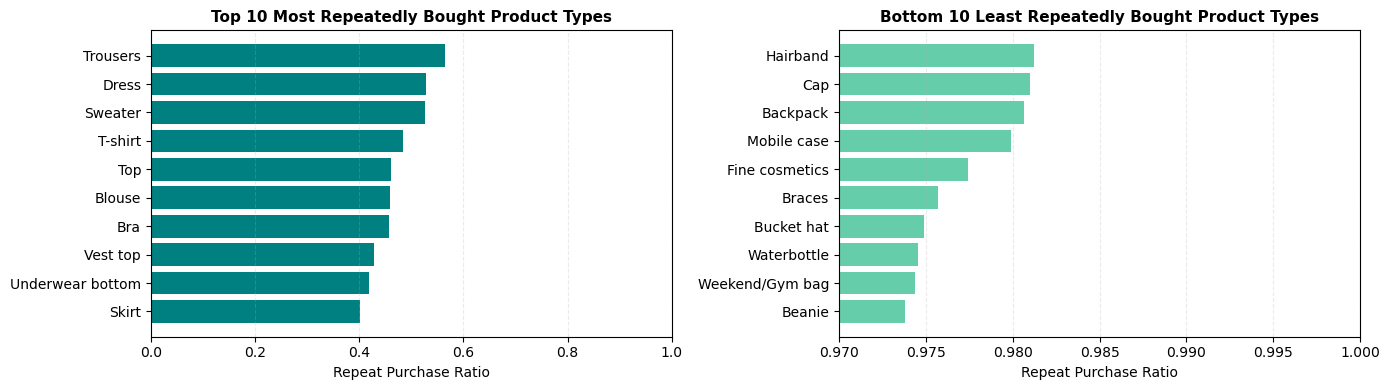

In [189]:
fig, axes = plt.subplots(1, 2, figsize=(14,4))

axes[0].barh(top_repeat['product_type_name'], top_repeat['repeat_ratio'], color='teal')
axes[0].set_title('Top 10 Most Repeatedly Bought Product Types', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Repeat Purchase Ratio')
axes[0].set_xlim(0, 1)
axes[0].invert_yaxis()
axes[0].grid(axis='x', linestyle='--', alpha=0.25)

axes[1].barh(bottom_repeat['product_type_name'], 1-bottom_repeat['repeat_ratio'], color='mediumaquamarine')
axes[1].set_title('Bottom 10 Least Repeatedly Bought Product Types', fontsize=11, fontweight='bold')
axes[1].set_xlabel('Repeat Purchase Ratio')
axes[1].set_xlim(0.97, 1)
axes[1].invert_yaxis()
axes[1].grid(axis='x', linestyle='--', alpha=0.25)

plt.tight_layout()
plt.savefig(f"{FIG_DIR}/eda_repeat_purchase_ratio.png", dpi=150, bbox_inches='tight')
plt.show()


#### Q9 Repeat Purchase Behavior by Product Type

These charts show which product types are **bought repeatedly** by customers and which are usually **one-time purchases**.

- The **most repeatedly bought items** are everyday essentials like **Trousers, Dresses, Sweaters, T-shirts, and Tops**, with repeat ratios above 40%.  
  These are regular clothing items that customers buy again over time, either replacing old ones or trying new styles.  
- The **least repeated items** include **accessories and small add-ons** such as **Hairbands, Caps, and Backpacks**, which are mostly one-time purchases.

This analysis helps identify products suited for **reorder recommendations** (like basics) and those better for **cross-selling** (like accessories).


# Conclusion

The Exploratory Data Analysis (EDA) of the H&M Personalized Fashion Recommendation dataset provided important insights about customers, products, and their shopping behavior.

### Key Findings
- **Customer Insights:**  
  Most customers are between **20–35 years old**, with a majority being **active club members**. However, many customers are not subscribed to fashion newsletters or communication updates.

- **Product Insights:**  
  H&M’s catalog is mainly focused on **Ladieswear** and **casual essentials** like **Trousers, Dresses, and Sweaters**.  
  Products with **solid colors (especially Black, Blue, and White)** dominate both in quantity and sales, showing a strong customer preference for neutral and simple styles.

- **Sales & Behavior Trends:**  
  - **In-store purchases** have larger basket sizes and higher spending compared to online shopping.  
  - Most customers are **one-time or occasional buyers**, but a small group of loyal shoppers generates a majority of total sales (the 80/20 pattern).  
  - **Essential items** like T-shirts and trousers are frequently repurchased, while **accessories** and small items are mostly one-time buys.

- **Customer Segmentation:**  
  Shopping preferences differ by age.  
  - **Younger customers** prefer trendy and colorful products.  
  - **Adults** show balanced purchasing habits.  
  - **Older customers** focus on comfort and neutral colors.

### Business Implications
These insights can guide how H&M builds its **recommendation system** and marketing strategies:
- Suggest **repeat or similar items** for basics like T-shirts, trousers, and sweaters.  
- Use **cross-selling** for accessories and one-time purchase items.  
- Personalize recommendations by **age group** and **shopping channel** (online vs in-store).  
- Focus loyalty campaigns on **high-value repeat customers** to increase retention.

### Final Note
The analysis shows that customer behavior at H&M aligns closely with **fast-fashion trends** — quick interest in new items, preference for simple and versatile designs, and strong engagement from a small base of repeat buyers.  
These findings set a strong foundation for developing a **data-driven, personalized recommendation model** that can enhance customer experience and increase overall sales.
